In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter


# Supervised Texture Segmentation 1: Augmenting The Training Data
This is part one of four in a series of notebooks which use neural networks to perform supervised texture segmentation on the Outex dataset. The parts are found here:
1. Preparing the data
2. Neural Network model
3. Using Empirical Wavelets
4. Using Empirical Watershed Wavelets

We begin by looking at the data given by the Outex Dataset. 

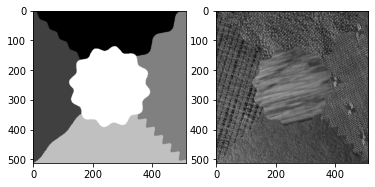

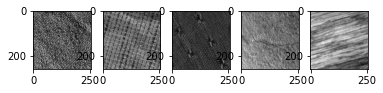

In [3]:
fol = "data/000/"
GT = plt.imread("data/ground_truth.ras");
problem = plt.imread(fol+"problem.ras");
Text1 = plt.imread(fol+'train_01.ras')
Text2 = plt.imread(fol+'train_02.ras')
Text3 = plt.imread(fol+'train_03.ras')
Text4 = plt.imread(fol+'train_04.ras')
Text5 = plt.imread(fol+'train_05.ras')


plt.figure()
plt.subplot(121)
plt.imshow(GT,cmap = 'gray')
plt.subplot(122)
plt.imshow(problem,cmap = 'gray')

plt.figure()
plt.subplot(151)
plt.imshow(Text1,cmap = 'gray')
plt.subplot(152)
plt.imshow(Text2,cmap = 'gray')
plt.subplot(153)
plt.imshow(Text3,cmap = 'gray')
plt.subplot(154)
plt.imshow(Text4,cmap = 'gray')
plt.subplot(155)
plt.imshow(Text5,cmap = 'gray')



What we see from these is that we are given a ground truth that holds true for all segmentation problems. For each one, we are given the composite texture and then a picture of each texture. While useful, we need more data. As such, we generate new ground truths. 

This is done by first generating an image of random numbers and then blurring it beyond recongnition. Then, using the median as a threshold, we are left a binary image. From there, we want to create a set of regions, and for this we create a labelling function that labels connected components. The function is given below.

In [4]:
def bwlabel(A,conn = 8):
    [h,w] = A.shape
    visited = np.zeros([h,w]).astype('bool')
    B = np.zeros([h,w])
    obj_num = 1
    
    for i in range(0,h):
        for j in range(0,w):
            
            if A[i,j] == 0:
                visited[i,j] = 1
            elif visited[i,j] == 1:
                continue
            else:
                stack = [[i,j]]
                
                while len(stack) > 0:
                    loc = stack[0]
                    stack.remove(loc)
                    
                    if visited[loc[0],loc[1]] == 1:
                        continue
                    visited[loc[0],loc[1]] = True
                    B[loc[0],loc[1]] = obj_num
                    
                    for p in range(-1,2):
                        for q in range(-1,2):
                            if p == 0 and q == 0:
                                continue
                            yval = loc[0] + p;
                            xval = loc[1] + q;
                            if yval < 0 or yval >= h or xval < 0 or xval >= w:
                                continue
                            if visited[yval,xval] == 1:
                                continue
                            if A[yval,xval] == 0:
                                continue
                            stack.append([yval,xval])
                obj_num += 1;
    return B

Using this function and the strategy outlined above, we can generate a labelled image. Note that we must choose an image size and a corresponding blurring variance $a$. If you play around with the value $a$, you notice that it makes a large difference on the number of regions. 

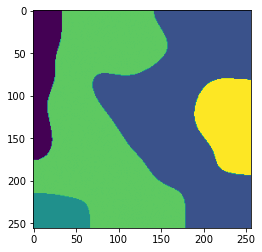

In [7]:
size = 256; a = 25
randimg = np.random.rand(size,size)
GT = gaussian_filter(randimg, sigma=a)
threshold = np.median(GT)
GT_1 = GT>threshold

GT_2 = -1*(GT_1-1)
L1 = bwlabel(GT_1)
L2 = bwlabel(GT_2)

L1[L1==0] = L2[L1==0] + np.max(L1)

plt.imshow(L1)

Because this is so dependent on our size and blurring variance $a$, we create a quick driver that makes 20 ground truth images and returns the number of regions. This way, we can test multiple values of $a$ and see which performs well for the number of regions we would like. 

In [8]:
def GTvarianceTesting(size,a):
    res = np.zeros(20)
    for i in range(0,20):
        randimg = np.random.rand(size,size)
        GT = gaussian_filter(randimg, sigma=a)
        threshold = np.median(GT)
        GT_1 = GT>threshold
        
        GT_2 = -1*(GT_1-1)
        L1 = bwlabel(GT_1)
        L2 = bwlabel(GT_2)     
        res[i] = np.max(L1) + np.max(L2)
    return res

Using this function, we test multiple values of $a$ for image sizes of $256\times 256$, which is the size of each training texture image. We print the median for each.

In [9]:
size = 256;
for i in range(5,55,5):
    print(i)
    print(np.median(GTvarianceTesting(size,i)))

5
42.0
10
16.0
15


KeyboardInterrupt: 

We now make a driver to save these ground truth images. 
We generate the image and check to see if we have five regions. We also include a function to guarantee that each region is at least of a certain size. If both of these are true, we save the image. If not, we try again. 

In [ ]:
def generateGTimages(n,a,size,minregion):
    i = 0
    count = 1
    while i < n:
        randimg = np.random.rand(size,size)
        GT = gaussian_filter(randimg, sigma=a)
        threshold = np.median(GT)
        GT_1 = GT>threshold
        
        GT_2 = -1*(GT_1-1)
        L1 = bwlabel(GT_1)
        L2 = bwlabel(GT_2)     
        
        if np.max(L1) + np.max(L2) == 5:
            L1[L1==0] = L2[L1==0] + np.max(L1)
            if checkRegSizes(L1,minregion):
                plt.imsave('data/GT/GT'+ str(i) + '.png',L1,cmap = "gray")
                print(i)
                i = i + 1;
            else:
                continue
        else:
            continue

def checkRegSizes(L,n):
    nregions = np.max(L).astype(int)
    flag = 1
    for i in range(0,nregions):
        if np.sum(L==i+1) < n:
            flag = 0
    return flag

Using this function, we generate 1000 images using blurring variance $a = 30$. (THIS TAKES TIME)

In [42]:
generateGTimages(1000,30,256,900)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Now that we have the ground truth images, we must generate textured images! For this, we create a function that reads each ground truth image, and then stitches together the image based on the textures. This is done simply enough by the function below.

In [19]:
def GT2Textures(fol,n):
    GT = plt.imread('data/GT/GT'+str(n)+'.png')
    GT = 4*GT[:,:,0]+1
    GT = GT.astype(int)
    texture = np.zeros(GT.shape)
    
    for i in range(1,6):
        temp = plt.imread('data/' + fol + '/train_0' + str(i) + '.ras')        
        texture[GT==i] = temp[GT==i]
    return texture

Using this, we generate images for folder '000'.

In [20]:
fol = '000'
for i in range(0,1000):
    texture = GT2Textures(fol,i)
    print(i)
    plt.imsave('Data/' +  fol + '/data'+ str(i) + '.png',texture)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27


And there we have it! A set of images to use as data for texture classification. See below for the resulting stiched texture images.

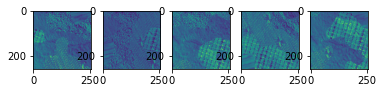

In [21]:
plt.figure()
plt.subplot(151)
Text = plt.imread('Data/000/data0.png')
plt.imshow(Text,cmap = 'gray')
plt.subplot(152)
Text = plt.imread('Data/000/data1.png')
plt.imshow(Text,cmap = 'gray')
plt.subplot(153)
Text = plt.imread('Data/000/data2.png')
plt.imshow(Text,cmap = 'gray')
plt.subplot(154)
Text = plt.imread('Data/000/data3.png')
plt.imshow(Text,cmap = 'gray')
plt.subplot(155)
Text = plt.imread('Data/000/data4.png')
plt.imshow(Text,cmap = 'gray')